In [2]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 300,"figure.facecolor":"w","figure.figsize": (15,10)})

from src.utl import remove_outliers_df
from src.config import dir_prep, dir_plots_group_cmpr


## set path and merge data

In [4]:
dat_pupil = pd.read_csv(Path.joinpath(dir_prep,"all_trials_pupil.csv"), index_col=False)
dat_fsr = pd.read_csv(Path.joinpath(dir_prep,"all_trials_fsr.csv"), index_col=False)

list(dat_pupil.columns)

['ID',
 'Trial n',
 'Feedback type',
 'Feedback angle',
 'Pupil size',
 'Percentage bad pupil samples',
 'Group']

In [5]:
full = pd.merge(dat_fsr, dat_pupil, on=["ID","Trial n","Group","Feedback type","Feedback angle"])
full = full.loc[:,~full.columns.str.startswith('Unnamed')]
list(full.columns)

['ID',
 'Trial n',
 'Feedback type',
 'Feedback angle',
 'Power [4-12]',
 'Power [1-3]',
 'Group',
 'Pupil size',
 'Percentage bad pupil samples']

## evaluate differences between angles and get correlation

In [20]:
cfg_out_ppl_per = 80
cr = full.copy()

cr = cr.loc[cr["Percentage bad pupil samples"] < cfg_out_ppl_per,:]
cr = cr[['ID','Group', 'Feedback type', 'Feedback angle','Power [4-12]','Pupil size']]


In [21]:
cr.groupby('Group').count()

,ID,Feedback type,Feedback angle,Power [4-12],Pupil size
Group,,,,,
c,61,61,61,61,61
p,179,179,179,179,178


In [22]:
diffs = cr.pivot_table(index=['ID','Group','Feedback type'],columns='Feedback angle',values=['Power [4-12]','Pupil size'],margins=False,aggfunc='mean').reset_index()
diffs['dPower'] = diffs['Power [4-12]']['high']-diffs['Power [4-12]']['low']
diffs['dPpl'] = diffs['Pupil size']['high']-diffs['Pupil size']['low']
diffs = remove_outliers_df(diffs,['dPower'],1)
diffs['dPower'] = abs(diffs['dPower'])

Working on column: dPower


In [23]:
diffs.groupby('Group').count()

ID Feedback type Power [4-12]     Pupil size     dPower dPpl
Feedback angle                           high low       high low            
Group                                                                       
c               15            15           15  15         15  15     15   15
p               42            42           42  42         42  42     42   42

<AxesSubplot:>

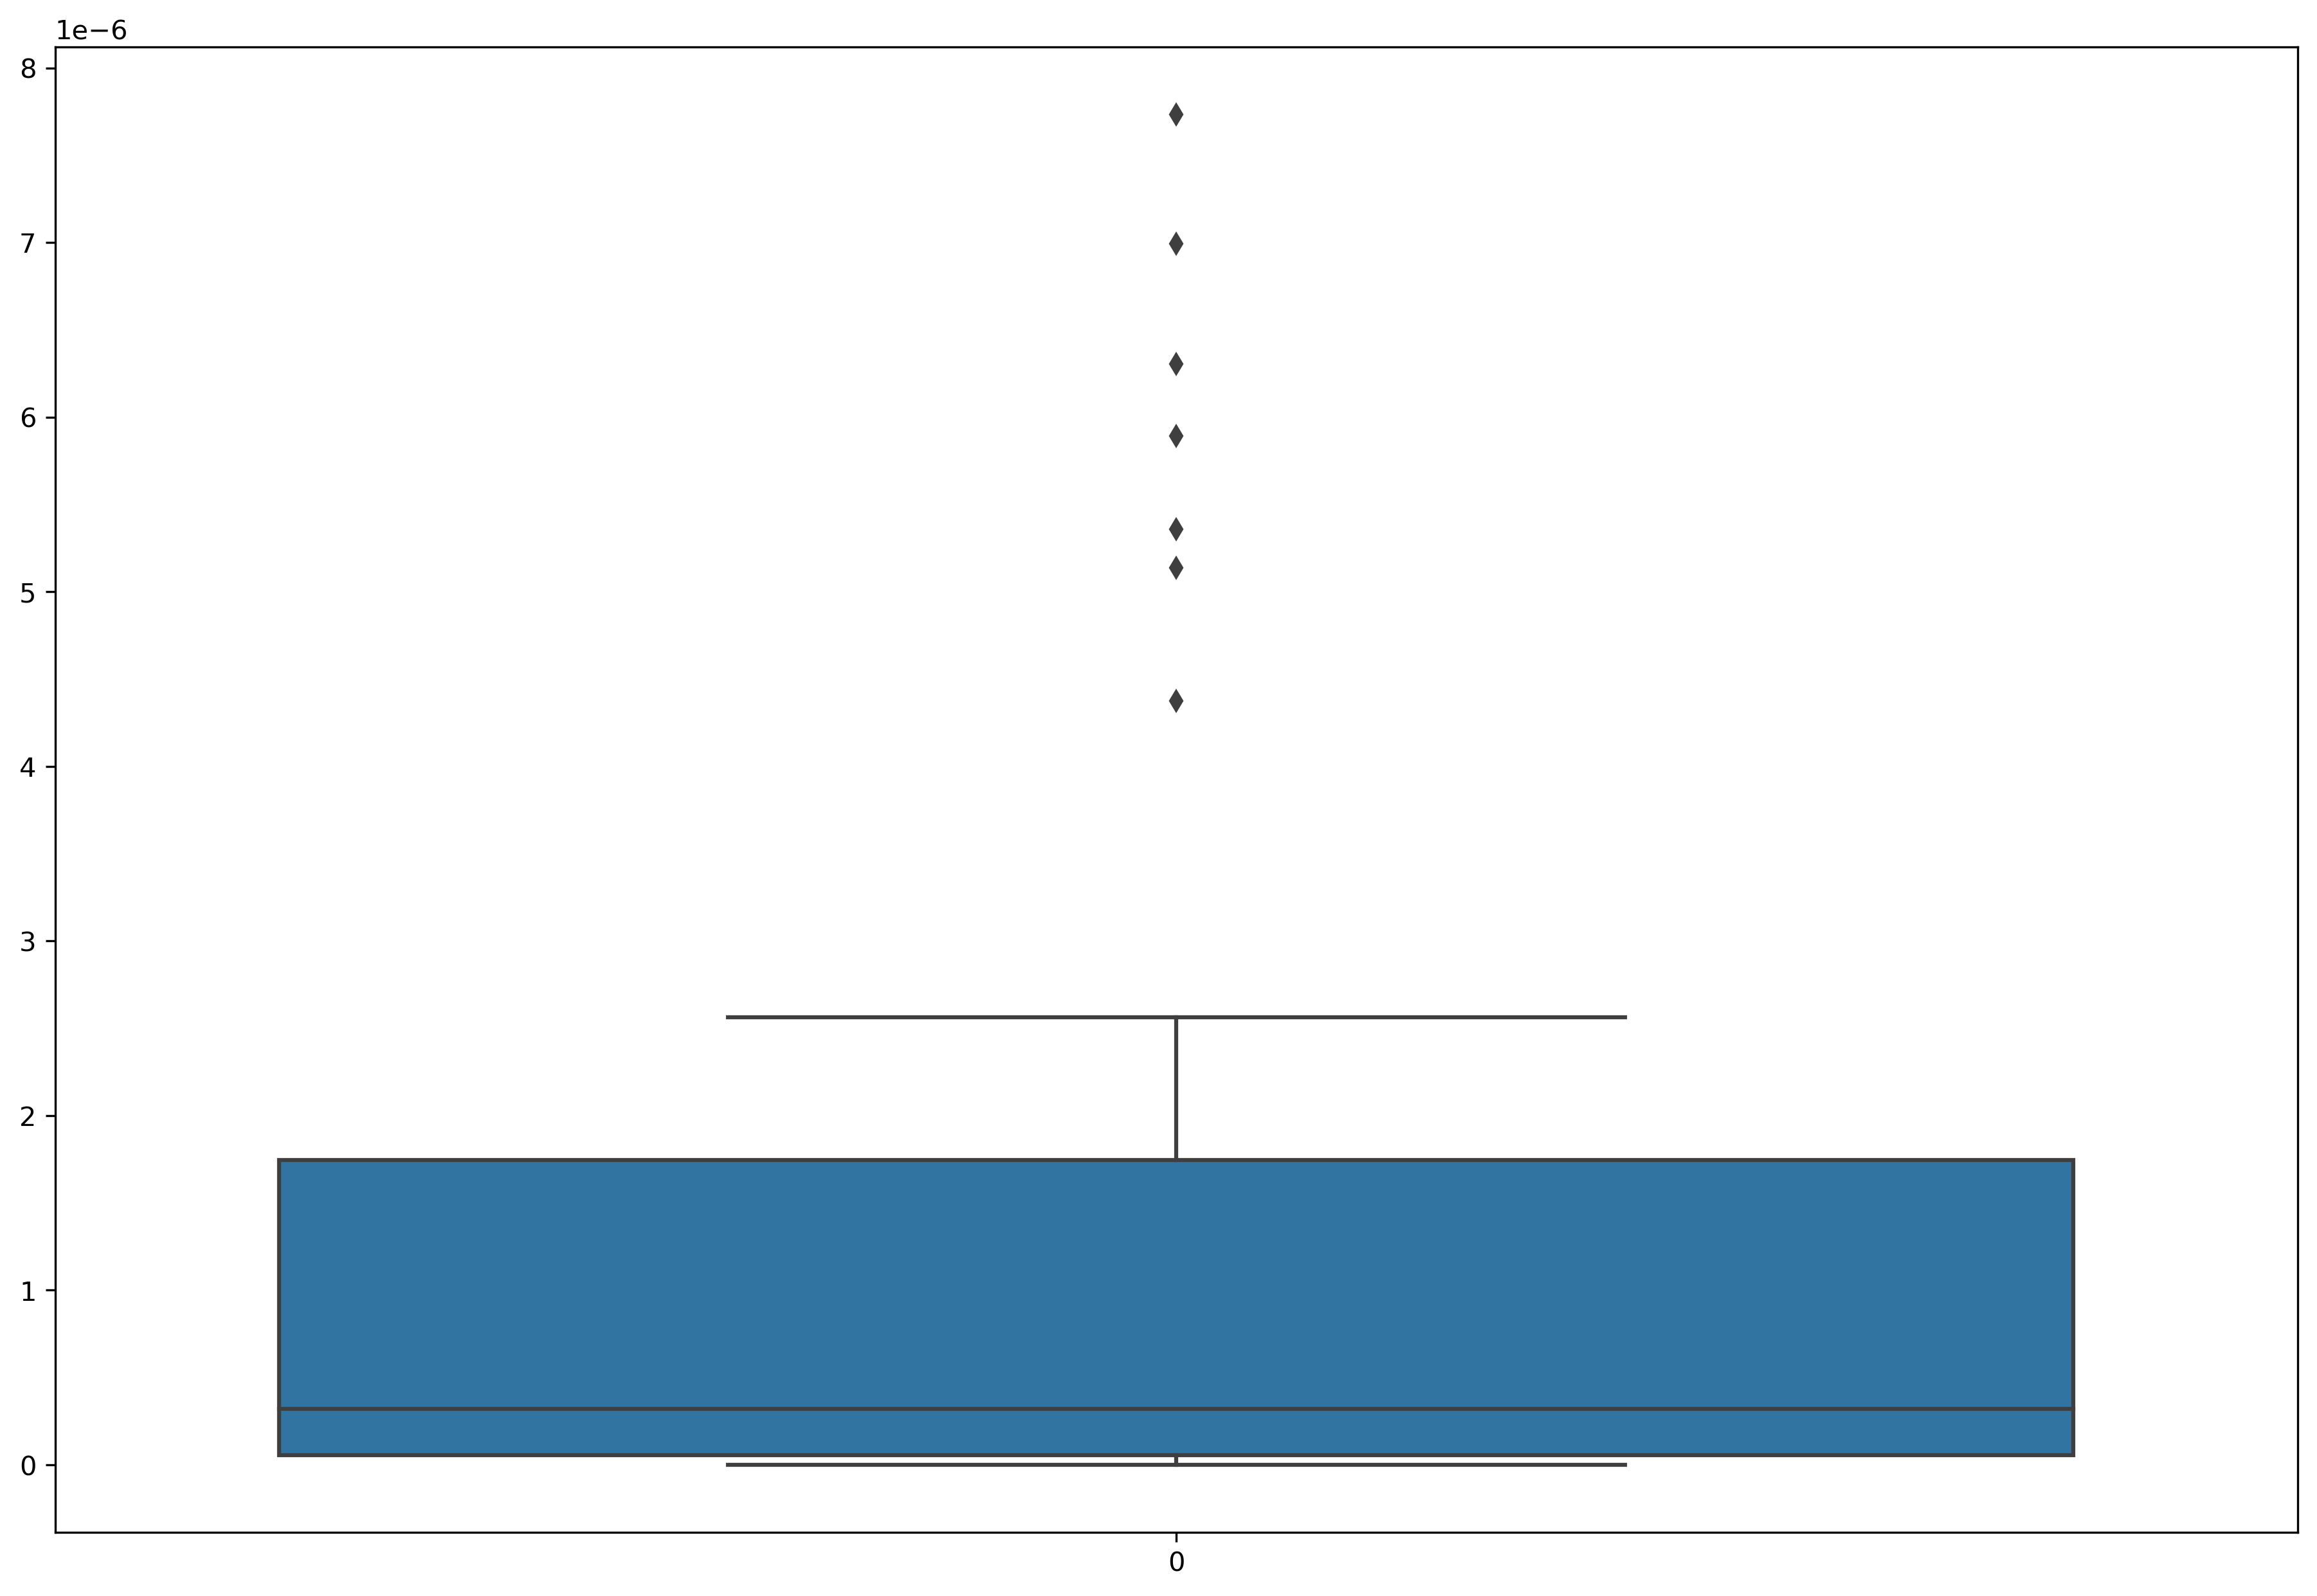

In [12]:
sns.boxplot(diffs['dPower'])

In [13]:
t_ppl_vo, p_ppl_vo = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for tremor is t[{df_vo}]={t_ppl_vo:.2f}, p:{p_ppl_vo:.3f}')
t_ppl_av, p_ppl_av = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv-visual for tremor is t[{df_va}]={t_ppl_av:.2f}, p:{p_ppl_av:.3f}')
t_ppl_ao, p_ppl_ao = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv only for tremor is t[{df_ao}]={t_ppl_ao:.2f}, p:{p_ppl_ao:.3f}')



Differences for group deltas in visual only for tremor is t[54]=20.00, p:0.442
Differences for group deltas in auditiv-visual for tremor is t[54]=nan, p:nan
Differences for group deltas in auditiv only for tremor is t[54]=24.00, p:0.871


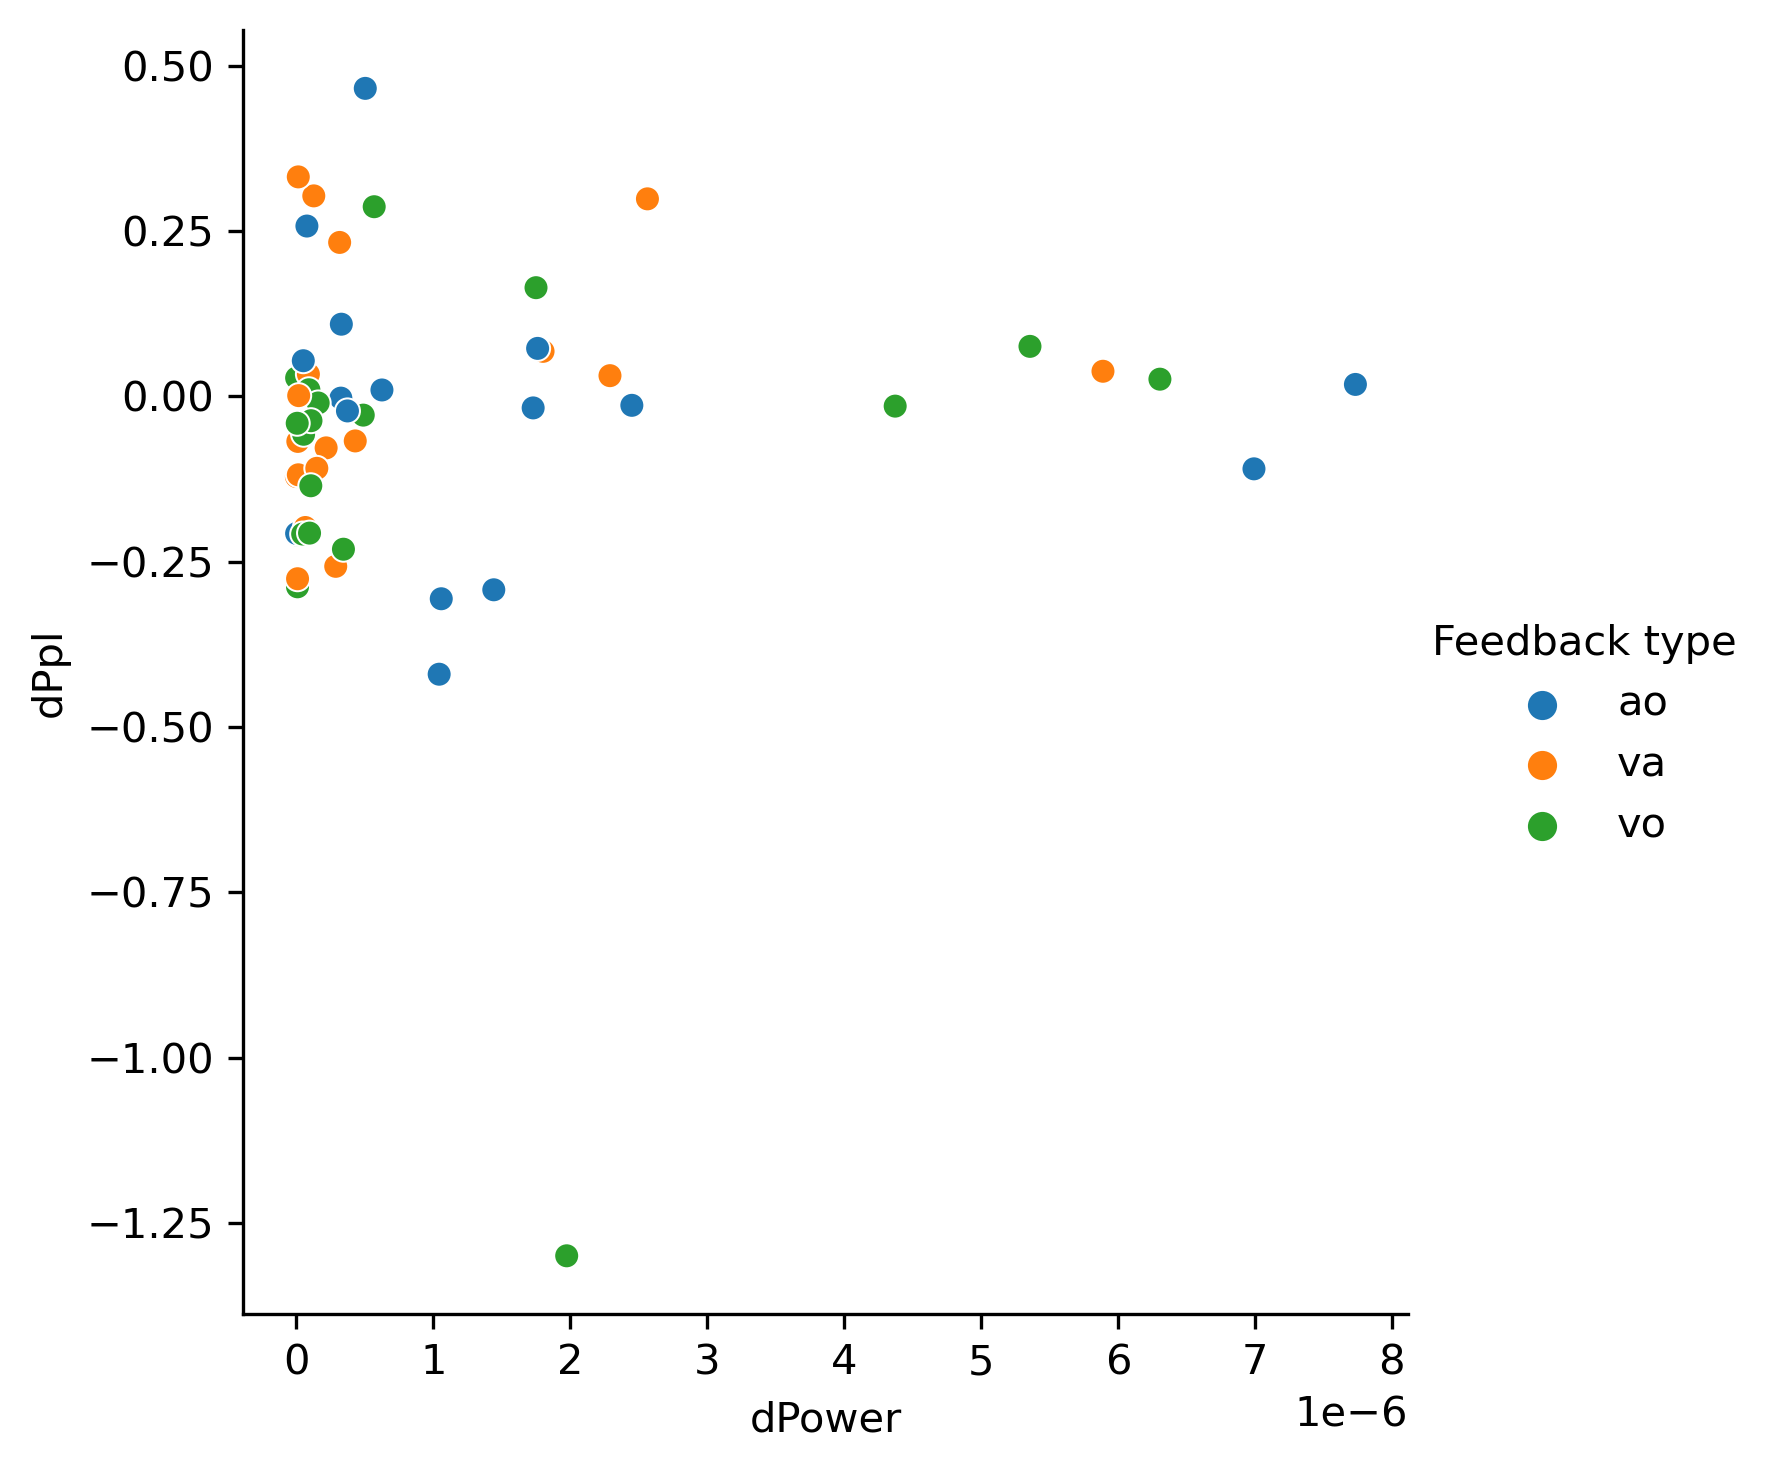

In [14]:
sns.relplot(
        data=diffs,x='dPower',y='dPpl',
        hue='Feedback type'
    )